# Developing, Training, and Deploying a TensorFlow model on Google Cloud Platform (completely within Jupyter)


In Chapter 9 of [Data Science on the Google Cloud Platform](http://shop.oreilly.com/product/0636920057628.do), I trained a TensorFlow Estimator model to predict flight delays.

In this notebook, we'll modernize the workflow:
* Use eager mode for TensorFlow development
* Use tf.data to write the input pipeline
* Run the notebook as-is on Cloud using Deep Learning VM or Kubeflow pipelines
* Deploy the trained model to AI Platform as a web service

The combination of eager mode, tf.data and DLVM/KFP makes this workflow a lot easier.
We don't need to deal with Python packages or Docker containers.

In [1]:
# change these to try this notebook out
# In "production", these will be replaced by the parameters passed to papermill
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'
DEVELOP_MODE = True
NBUCKETS = 5 # for embeddings
NUM_EXAMPLES = 1000*1000 # assume 1 million examples

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Creating the input data pipeline

In [4]:
DATA_BUCKET = "gs://cloud-training-demos/flights/chapter8/output/"
TRAIN_DATA_PATTERN = DATA_BUCKET + "train*"
VALID_DATA_PATTERN = DATA_BUCKET + "test*"

In [5]:
!gsutil ls $DATA_BUCKET

gs://cloud-training-demos/flights/chapter8/output/delays.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00000-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00001-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00002-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00003-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00004-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00005-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/testFlights-00006-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/trainFlights-00000-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/trainFlights-00001-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/trainFlights-00002-of-00007.csv
gs://cloud-training-demos/flights/chapter8/output/trainFlights-00003-of-00007.csv
gs://cloud-training-demos/flights/chapter8/o

### Use tf.data to read the CSV files

In [6]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.0.0-dev20190612


In [7]:
CSV_COLUMNS  = ('ontime,dep_delay,taxiout,distance,avg_dep_delay,avg_arr_delay' + \
                ',carrier,dep_lat,dep_lon,arr_lat,arr_lon,origin,dest').split(',')
LABEL_COLUMN = 'ontime'
DEFAULTS     = [[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],\
                ['na'],[0.0],[0.0],[0.0],[0.0],['na'],['na']]

def load_dataset(pattern, batch_size=1):
  return tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)

In [8]:
if DEVELOP_MODE:
    dataset = load_dataset(TRAIN_DATA_PATTERN)
    for n, data in enumerate(dataset):
        numpy_data = {k: v.numpy() for k, v in data.items()} # .numpy() works only in eager mode
        print(numpy_data)
        if n>3: break

W0617 21:54:18.114314 139645253560064 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:498: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
W0617 21:54:18.152702 139645253560064 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:211: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizati

{'dep_delay': array([24.], dtype=float32), 'avg_dep_delay': array([23.81102], dtype=float32), 'avg_arr_delay': array([-7.8], dtype=float32), 'dest': array([b'BOI'], dtype=object), 'arr_lon': array([-116.22278], dtype=float32), 'taxiout': array([14.], dtype=float32), 'ontime': array([1.], dtype=float32), 'origin': array([b'SFO'], dtype=object), 'dep_lat': array([37.61889], dtype=float32), 'arr_lat': array([43.564445], dtype=float32), 'carrier': array([b'OO'], dtype=object), 'dep_lon': array([-122.37556], dtype=float32), 'distance': array([522.], dtype=float32)}
{'dep_delay': array([0.], dtype=float32), 'avg_dep_delay': array([23.01731], dtype=float32), 'avg_arr_delay': array([3.5], dtype=float32), 'dest': array([b'BOI'], dtype=object), 'arr_lon': array([-116.22278], dtype=float32), 'taxiout': array([8.], dtype=float32), 'ontime': array([1.], dtype=float32), 'origin': array([b'PHX'], dtype=object), 'dep_lat': array([33.434166], dtype=float32), 'arr_lat': array([43.564445], dtype=float32)

In [9]:
%%writefile example_input.json
{"dep_delay": 14.0, "taxiout": 13.0, "distance": 319.0, "avg_dep_delay": 25.863039, "avg_arr_delay": 27.0, "carrier": "WN", "dep_lat": 32.84722, "dep_lon": -96.85167, "arr_lat": 31.9425, "arr_lon": -102.20194, "origin": "DAL", "dest": "MAF"}
{"dep_delay": -9.0, "taxiout": 21.0, "distance": 301.0, "avg_dep_delay": 41.050808, "avg_arr_delay": -7.0, "carrier": "EV", "dep_lat": 29.984444, "dep_lon": -95.34139, "arr_lat": 27.544167, "arr_lon": -99.46167, "origin": "IAH", "dest": "LRD"}

Overwriting example_input.json


In [10]:
def features_and_labels(features):
  label = features.pop('ontime') # this is what we will train for
  return features, label

def prepare_dataset(pattern, batch_size, truncate=None, mode=tf.estimator.ModeKeys.TRAIN):
  dataset = load_dataset(pattern, batch_size)
  dataset = dataset.map(features_and_labels)
  dataset = dataset.cache()
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(1000)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset


if DEVELOP_MODE:
    print("Calling prepare")
    one_item = prepare_dataset(TRAIN_DATA_PATTERN, batch_size=5, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Calling prepare
[(OrderedDict([('dep_delay', <tf.Tensor: id=345, shape=(5,), dtype=float32, numpy=array([11., -1., -1., -1.,  8.], dtype=float32)>), ('taxiout', <tf.Tensor: id=351, shape=(5,), dtype=float32, numpy=array([12., 17., 15., 25., 27.], dtype=float32)>), ('distance', <tf.Tensor: id=349, shape=(5,), dtype=float32, numpy=array([444., 259., 259., 259., 677.], dtype=float32)>), ('avg_dep_delay', <tf.Tensor: id=343, shape=(5,), dtype=float32, numpy=
array([29.128044, 28.031101, 25.900959, 21.925058, 34.119404],
      dtype=float32)>), ('avg_arr_delay', <tf.Tensor: id=342, shape=(5,), dtype=float32, numpy=
array([ 32.      ,   6.5     , -11.5     , -13.      ,  33.666668],
      dtype=float32)>), ('carrier', <tf.Tensor: id=344, shape=(5,), dtype=string, numpy=array([b'B6', b'DL', b'DL', b'DL', b'EV'], dtype=object)>), ('dep_lat', <tf.Tensor: id=346, shape=(5,), dtype=float32, numpy=
array([38.851944, 33.636665, 33.636665, 33.636665, 41.979443],
      dtype=float32)>), ('dep_lon', <

## Create TensorFlow wide-and-deep model

We'll create feature columns, and do some discretization and feature engineering.
See the book for details.

In [11]:
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            ('dep_delay,taxiout,distance,avg_dep_delay,avg_arr_delay' +
             ',dep_lat,dep_lon,arr_lat,arr_lon').split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000)
}

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

### Feature engineering

In [12]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_lat', 'arr_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_lon', 'arr_lon']
})

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column([disc['d_dep_lat'], disc['d_dep_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column([disc['d_arr_lat'], disc['d_arr_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)
#sparse['ori_dest'] = tf.feature_column.crossed_column(['origin', 'dest'], hash_bucket_size=1000)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, 10)
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['dest', 'dep_loc', 'carrier', 'arr_loc', 'origin', 'dep_arr'])
dict_keys(['dep_delay', 'avg_dep_delay', 'embed_dep_loc', 'avg_arr_delay', 'embed_arr_loc', 'arr_lon', 'taxiout', 'embed_origin', 'embed_dep_arr', 'dep_lat', 'arr_lat', 'dep_lon', 'embed_carrier', 'distance', 'embed_dest'])


## Train the model and evaluate once in a while

Also checkpoint

In [13]:
model_dir='gs://{}/flights/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = model_dir  # needed for deployment
print('Writing trained model to {}'.format(model_dir))

Writing trained model to gs://cloud-training-demos-ml/flights/trained_model


In [14]:
!gsutil -m rm -rf $OUTDIR

CommandException: 1 files/objects could not be removed.


W0617 21:54:26.702825 139645253560064 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:3090: CrossedColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0617 21:54:26.703989 139645253560064 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:299: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.
W0617 21:54:26.713676 139645253560064 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:3090: Vocabulary

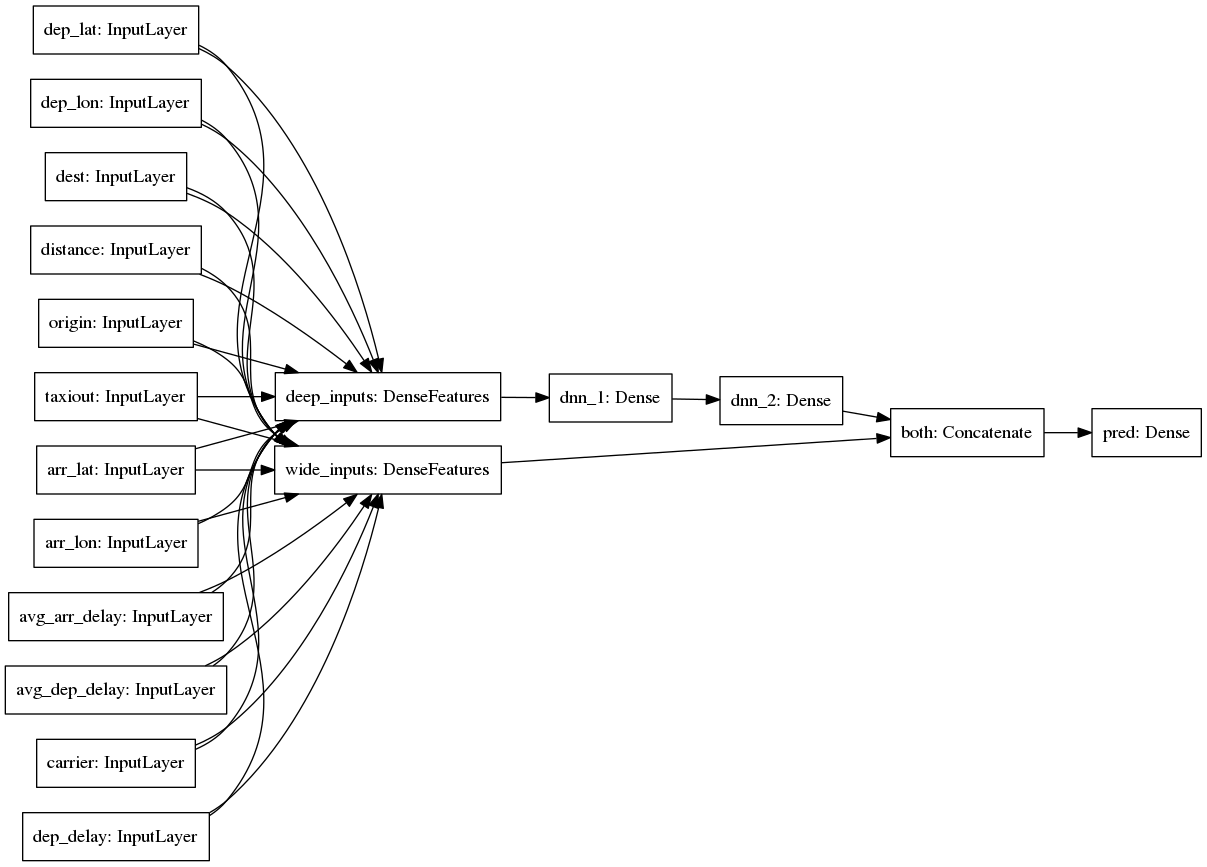

In [15]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    for layerno, numnodes in enumerate(dnn_hidden_units):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = [64, 32])
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

In [16]:
# training and evaluation dataset
train_batch_size = 64
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
else:
    eval_batch_size = 10000
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
train_dataset = prepare_dataset(TRAIN_DATA_PATTERN, train_batch_size)
eval_dataset = prepare_dataset(VALID_DATA_PATTERN, eval_batch_size, eval_batch_size*10, tf.estimator.ModeKeys.EVAL)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(model_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
1/3 [=========>....................] - ETA: 10s - loss: 0.6895 - accuracy: 0.7188
Epoch 00001: saving model to gs://cloud-training-demos-ml/flights/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 22s 7s/step - loss: 0.6234 - accuracy: 0.7604 - val_loss: 0.4403 - val_accuracy: 0.8373
Epoch 2/2
1/3 [=========>....................] - ETA: 0s - loss: 0.4487 - accuracy: 0.8281
Epoch 00002: saving model to gs://cloud-training-demos-ml/flights/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 13s 4s/step - loss: 0.4633 - accuracy: 0.8125 - val_loss: 0.4601 - val_accuracy: 0.8260


In [17]:
print(history.history.keys())

dict_keys(['accuracy', 'val_accuracy', 'loss', 'val_loss'])


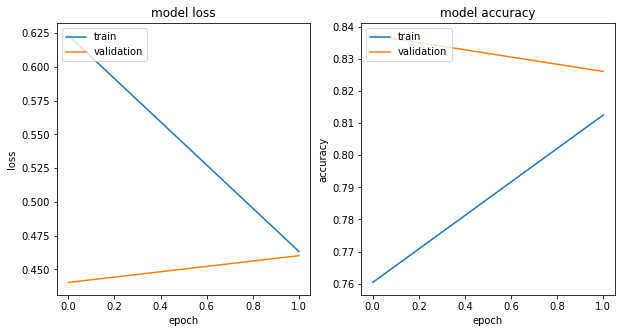

In [18]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Export and deploy the trained model

In [19]:
import time
export_dir = '{}/export/flights_{}'.format(model_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.keras.experimental.export_saved_model(model, export_dir)

Exporting to gs://cloud-training-demos-ml/flights/trained_model/export/flights_20190617-215559


ValueError: Unknown feature_column_v2: CrossedColumn

In [25]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --dir ${model_dir} --all

gs://cloud-training-demos-ml/flights/trained_model/export/exporter/1553294283/

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['arr_lat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_7:0
    inputs['arr_lon'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_8:0
    inputs['avg_arr_delay'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_4:0
    inputs['avg_dep_delay'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_3:0
    inputs['carrier'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: Placeholder_9:0
    inputs['dep_delay'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder:0
    inputs['dep_lat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
     

In [ ]:
%%bash
MODEL_NAME="flights"
MODEL_VERSION="kfp"
TFVERSION="2.0"
MODEL_LOCATION=$(gsutil ls ${OUTDIR}/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#yes | gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

In [ ]:
!gcloud ml-engine predict --model=flights --version=kfp --json-instances=example_input.json

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License